In [1]:
import sys
sys.path.append("src")

from loader_functions import load_spatial_data, check_data_load
from model_setup import engineer_model_dataset, add_kde_regression_features
from spreg_functions import fit_lightgbm_kde_dist

In [2]:
out = load_spatial_data(
    study_path="data/teesside_boroughs.gpkg",
    
    study_filter=("lad21nm", ["Middlesbrough", "Stockton-on-Tees"]),
    crime_path="data/teesside_crime20222023.gpkg",
    crime_filter=("subgroup", ["Robbery"]),
    poi_path="data/teesside_points_of_interest.csv",
    poi_layer="pois",
    poi_filter=("Code", [6,33,38,39,55,65,68,71,79,84,95,96,99,103,105,106,119,122,134,135,136,137,139,150,151,163,168,172,])
)

study_area = out["study_area"]
crime = out["crime_data"]
poi = out["points_of_interest"]

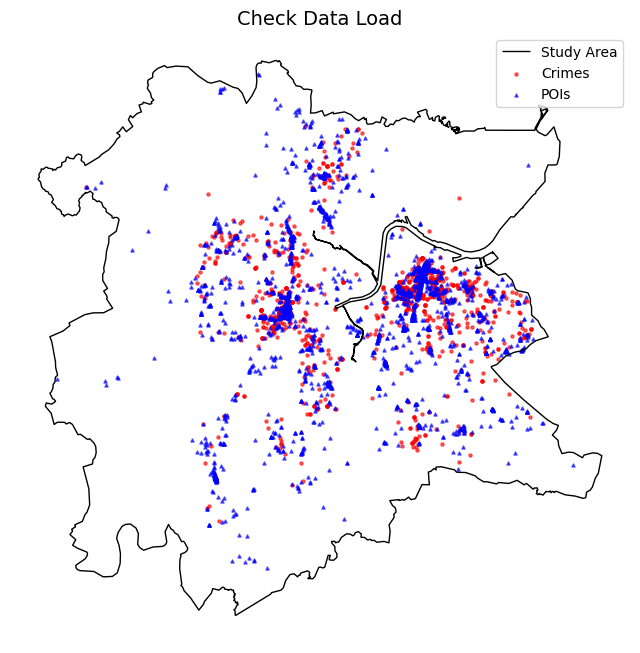

In [3]:
check_data_load(out)

In [4]:
poi.columns

Index(['Name', 'LongDescription', 'Category', 'SubCategory', 'Code', 'Address',
       'Postcode', 'Chain', 'Borough', 'geometry'],
      dtype='object')

In [5]:
features = engineer_model_dataset(
    loader_out=out,
    unit_type="hex",              # "hex" or "grid"
    grid_size_m=60.0,
    hex_edge_km=0.075863783,
    crime_bandwidth_m=300.0,
    poi_mode="both",              # "both" | "kde" | "distance" | "none"
    poi_bandwidth_m=300.0,
    poi_category_col="SubCategory"  # your POI category field
)

units = features["units"]   # polygons (grid/hex)
spine = features["spine"]   # centroids (analysis units)
model_df = features["model"]   # regression-ready features

<Axes: >

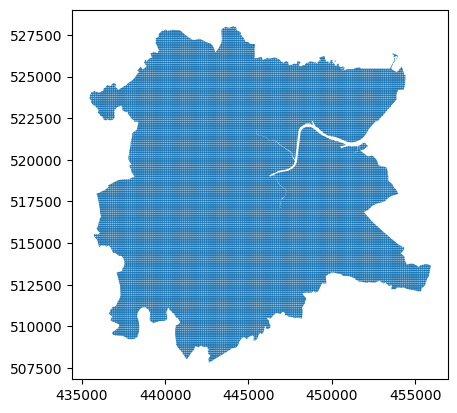

In [6]:
units.plot()

In [7]:
model_df.sort_values('crime_count', ascending=False).head()

,unit_id,geometry,crime_count,crime_kde,Dist_Gas Station,KDE_Gas Station,Dist_Bars and Pubs,KDE_Bars and Pubs,Dist_Convenience Store,KDE_Convenience Store,...,Dist_Hostel,KDE_Hostel,Dist_Pawnshop,KDE_Pawnshop,Dist_Money Transfer,KDE_Money Transfer,Dist_Cinema,KDE_Cinema,Dist_Check Cashing,KDE_Check Cashing
10803,10803,POINT (449299.744 519796.495),20,1.701100e-07,771.818235,2.364184e-09,25.554110,1.452604e-07,42.547466,1.062077e-07,...,738.953521,3.929398e-08,402.366905,8.961662e-08,550.051261,8.875102e-08,885.020770,5.697772e-09,434.947588,2.206800e-07
10400,10400,POINT (449982.518 519402.296),19,8.060791e-08,47.064813,4.062272e-08,310.956212,2.390013e-08,30.928465,5.178291e-08,...,951.337284,3.129496e-09,968.114914,1.113692e-09,3.652541,4.127422e-07,774.545610,1.577830e-08,997.201463,2.368576e-09
11072,11072,POINT (449754.927 520059.295),16,1.305459e-07,737.583618,3.042954e-09,179.502254,1.363889e-07,168.006900,4.356461e-08,...,291.213830,4.045067e-07,289.186119,1.387865e-07,444.955718,1.882070e-07,364.759789,2.111069e-07,380.990846,3.635816e-07
11333,11333,POINT (449527.335 520322.095),15,1.445284e-07,480.495478,1.147467e-08,40.051660,2.052515e-07,95.120390,4.317567e-08,...,169.320033,6.436178e-07,58.850539,2.723714e-07,102.362974,1.814145e-07,596.395935,6.128189e-08,75.869960,8.128376e-07
10529,10529,POINT (448958.357 519533.695),13,1.672996e-07,1018.281902,2.001610e-10,199.047340,3.867091e-08,73.002126,1.434615e-07,...,1128.055686,5.523277e-10,774.464565,6.225345e-09,866.306222,6.425000e-09,1308.607321,3.264400e-11,818.741983,1.314867e-08


## Add SocioDemographic Feats

In [8]:
features = add_kde_regression_features(
    features,
    source_path="censusoa_data_cleveland.gpkg",  # or .csv with WKT/geometry column
    pop_col="resident_pop",
    count_cols=("resident_pop","youth_workday_pop","workers_workday_pop","elderly_workday_pop"),
    avg_cols=("income_deprivation","employment_deprivation"),
    bandwidth_m=500,
    cell_size=100,
    kernel="quartic",
    layer=None,
    fill_avg="zero"
)
gdf_out = features["model"]

model_df = features["model"] 
model_df.sort_values('crime_count', ascending=False).head()

,unit_id,geometry,crime_count,crime_kde,Dist_Gas Station,KDE_Gas Station,Dist_Bars and Pubs,KDE_Bars and Pubs,Dist_Convenience Store,KDE_Convenience Store,...,KDE_resident_pop,KWS_resident_pop,KDE_youth_workday_pop,KWS_youth_workday_pop,KDE_workers_workday_pop,KWS_workers_workday_pop,KDE_elderly_workday_pop,KWS_elderly_workday_pop,AVG_income_deprivation,AVG_employment_deprivation
10803,10803,POINT (449299.744 519796.495),20,1.701100e-07,771.818235,2.364184e-09,25.554110,1.452604e-07,42.547466,1.062077e-07,...,0.006921,1811.912476,0.001634,427.772430,0.006405,1676.799194,0.000621,162.595596,53.246666,0.179435
10400,10400,POINT (449982.518 519402.296),19,8.060791e-08,47.064813,4.062272e-08,310.956212,2.390013e-08,30.928465,5.178291e-08,...,0.008414,2202.754639,0.002081,544.928162,0.006572,1720.623047,0.000690,180.702972,50.329712,0.190097
11072,11072,POINT (449754.927 520059.295),16,1.305459e-07,737.583618,3.042954e-09,179.502254,1.363889e-07,168.006900,4.356461e-08,...,0.003335,873.152466,0.000551,144.148926,0.005466,1431.052612,0.000243,63.747421,51.263195,0.176560
11333,11333,POINT (449527.335 520322.095),15,1.445284e-07,480.495478,1.147467e-08,40.051660,2.052515e-07,95.120390,4.317567e-08,...,0.002938,769.270142,0.000214,55.922176,0.010304,2697.617432,0.000476,124.538895,54.639542,0.205164
10529,10529,POINT (448958.357 519533.695),13,1.672996e-07,1018.281902,2.001610e-10,199.047340,3.867091e-08,73.002126,1.434615e-07,...,0.009313,2438.029541,0.002355,616.517151,0.007823,2048.076172,0.000905,236.867081,58.576717,0.205614


## Run Model

In [9]:
model_out = fit_lightgbm_kde_dist(df=model_df, use_crime_count=True)
model_out["feature_summary"].head(10)
model_out["contrib_df"].head(5)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16830
[LightGBM] [Info] Number of data points in the train set: 14322, number of used features: 66
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.065633
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	valid_0's l2: 0.262874
Holdout metrics for crime_count: {'MAE': 0.10028909932696775, 'RMSE': 0.512712303561624, 'R2': 0.3658448927789957}

Top positive drivers (plain language):
- Higher **KDE_Convenience Store** tended to increase predicted crime (avg +contrib ≈ 0.021).
- Higher **KDE_Take Out and Delivery Only** tended to increase predicted crime (avg +contrib ≈ 0.008).
- Higher **Dist_Night

,unit_id,prediction,bias,KDE_Gas Station,KDE_Bars and Pubs,KDE_Convenience Store,KDE_Take Out and Delivery Only,KDE_School,KDE_Hair and Beauty,KDE_Guest House,...,Dist_Pawnshop,Dist_Money Transfer,Dist_Cinema,Dist_Check Cashing,KWS_resident_pop,KWS_youth_workday_pop,KWS_workers_workday_pop,KWS_elderly_workday_pop,AVG_income_deprivation,AVG_employment_deprivation
0,0,0.002116,0.065417,0.000147,-0.000147,-0.018365,-0.008795,-0.0001,-0.000045,-0.000636,...,-0.000227,0.000588,-0.00002,0.000114,-0.000096,-0.000923,-0.000042,0.000221,-0.007255,-0.00256
1,1,0.002116,0.065417,0.000147,-0.000147,-0.018365,-0.008795,-0.0001,-0.000045,-0.000636,...,-0.000227,0.000588,-0.00002,0.000114,-0.000096,-0.000923,-0.000042,0.000221,-0.007263,-0.00256
2,2,0.002116,0.065417,0.000147,-0.000147,-0.018365,-0.008795,-0.0001,-0.000045,-0.000636,...,-0.000227,0.000588,-0.00002,0.000114,-0.000096,-0.000923,-0.000042,0.000221,-0.007263,-0.00256
3,3,0.002116,0.065417,0.000147,-0.000147,-0.018365,-0.008795,-0.0001,-0.000045,-0.000636,...,-0.000227,0.000588,-0.00002,0.000114,-0.000096,-0.000923,-0.000042,0.000221,-0.007263,-0.00256
4,4,0.002116,0.065417,0.000147,-0.000147,-0.018365,-0.008795,-0.0001,-0.000045,-0.000636,...,-0.000227,0.000588,-0.00002,0.000114,-0.000096,-0.000923,-0.000042,0.000221,-0.007265,-0.00256


In [10]:
from spreg_functions import explain_and_prepare_contribs

explain_out = explain_and_prepare_contribs(model_out, top_k_global=10, unit_row=0, make_zscore=True)
explain_out["contrib_all"].head(3)
explain_out["contrib_positive_only"].head(3)
explain_out["contrib_negative_only"].head(3)
explain_out["contrib_zscore"].head(3)

Narrative — top positive global drivers:
- Higher **KDE_Convenience Store** tended to increase predicted crime (avg +contrib ≈ 0.021).
- Higher **KDE_Take Out and Delivery Only** tended to increase predicted crime (avg +contrib ≈ 0.008).
- Higher **Dist_Night Club** tended to increase predicted crime (avg +contrib ≈ 0.005).
- Higher **Dist_ATM** tended to increase predicted crime (avg +contrib ≈ 0.005).
- Higher **KDE_youth_workday_pop** tended to increase predicted crime (avg +contrib ≈ 0.004).
- Higher **AVG_income_deprivation** tended to increase predicted crime (avg +contrib ≈ 0.004).
- Higher **Dist_Convenience Store** tended to increase predicted crime (avg +contrib ≈ 0.003).
- Higher **KDE_ATM** tended to increase predicted crime (avg +contrib ≈ 0.003).
- Higher **Dist_Grocery** tended to increase predicted crime (avg +contrib ≈ 0.002).
- Higher **KDE_Grocery** tended to increase predicted crime (avg +contrib ≈ 0.002).


,feature,mean_positive_contrib,mean_abs_contrib,gain_importance,split_importance
0,KDE_Convenience Store,0.020646,0.036735,5745.458592,94
1,KDE_Take Out and Delivery Only,0.008289,0.015354,708.778192,56
8,Dist_Night Club,0.004776,0.005390,158.728612,35
4,Dist_ATM,0.004502,0.008387,322.101871,75
3,KDE_youth_workday_pop,0.003989,0.009804,292.065227,65
2,AVG_income_deprivation,0.003500,0.010387,508.421090,76
6,Dist_Convenience Store,0.002895,0.007357,1034.387114,98
12,KDE_ATM,0.002541,0.004082,216.767840,55
9,Dist_Grocery,0.002412,0.005056,876.492242,54
11,KDE_Grocery,0.002389,0.004300,941.272477,50



Local explanation — unit: 0.0 | Prediction=0.002 | Bias=0.065
Top positive pushes:


,contribution
Dist_Night Club,0.011801
KDE_Night Club,0.003406
KDE_Food-Beverage Specialty Store,0.002707
Dist_Motel,0.002251
Dist_Hair and Beauty,0.001690
Dist_Hostel,0.000737
Dist_Money Transfer,0.000588
KDE_Vaping Store,0.000426
KDE_Wine and Liquor,0.000387
KDE_Tourist Attraction,0.000297


Top negative pushes:


,contribution
KDE_Convenience Store,-0.018365
KDE_Department Store,-0.011811
KDE_Take Out and Delivery Only,-0.008795
KDE_youth_workday_pop,-0.007303
AVG_income_deprivation,-0.007255
Dist_ATM,-0.003656
Dist_Convenience Store,-0.003022
KDE_Money Transfer,-0.002603
AVG_employment_deprivation,-0.002560
KDE_Jeweler,-0.002201


,unit_id,z_KDE_Gas Station,z_KDE_Bars and Pubs,z_KDE_Convenience Store,z_KDE_Take Out and Delivery Only,z_KDE_School,z_KDE_Hair and Beauty,z_KDE_Guest House,z_KDE_Grocery,z_KDE_ATM,...,z_Dist_Pawnshop,z_Dist_Money Transfer,z_Dist_Cinema,z_Dist_Check Cashing,z_KWS_resident_pop,z_KWS_youth_workday_pop,z_KWS_workers_workday_pop,z_KWS_elderly_workday_pop,z_AVG_income_deprivation,z_AVG_employment_deprivation
0,0,-0.02082,-0.019452,-0.194975,-0.337485,-0.018009,-0.061627,-0.038259,-0.094986,-0.148198,...,-0.037688,0.106699,0.058575,0.00653,0.010914,-0.319949,0.006787,0.104874,-0.232715,-0.151419
1,1,-0.02082,-0.019452,-0.194975,-0.337485,-0.018009,-0.061627,-0.038259,-0.094986,-0.148723,...,-0.037688,0.106699,0.058575,0.00653,0.010914,-0.319949,0.006787,0.104874,-0.233179,-0.151419
2,2,-0.02082,-0.019452,-0.194975,-0.337485,-0.018009,-0.061627,-0.038259,-0.094986,-0.148723,...,-0.037688,0.106699,0.058575,0.00653,0.010914,-0.319949,0.006787,0.104874,-0.233179,-0.151419


In [11]:
end_user_output = explain_out["contrib_zscore"].merge(model_df[['unit_id', 'geometry', 'crime_count']], on='unit_id', how='inner')
end_user_output = end_user_output.merge(model_out["contrib_df"], on='unit_id', how='inner')
end_user_output.to_csv('testing_end_user_outputs.csv', index=False)